# INFO 4604: Machine Learning Course Project
### Kobe Bryant Career Data Machine Learning/Visualization/Analysis

Group Members: Lucas Bouchard, Steven Rothaus, Harold Chang, Justin Klemplerer

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('data.csv')

What is expected for this project

A template for a supervised classification project involves the following experiments.
Expected experiments:

•At least 3 different classification algorithms 

•Tune at least one hyperparameterto adjust bias/variance(on validation data, or with cross-validation) for each classifier PRETY MUCH CHECK "NOT SURE HOW OPTIMEZED THEY NEED TO BE"

•Experiment with feature selection and/or dimensionality reduction

•Perform error analysis (do at least one of the following for an individual project, at least two for a two-person project, and all three for a three-person project)
   
    oAnalyze the confusion matrix
    oExamine and describe theindividual instances the classifier  misclassifies
    oTry to interpret what the classifier is doing (e.g., look at the weights to understand whichfeatures are predictive)

# Start of Clean and EDA

In [3]:
df.head(2)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2


Remove Useless data


In [4]:
df.drop(['lat', 'lon','team_name','team_id'], axis=1, inplace=True)

Convert seasons to integers

In [5]:
df['season']=df['season'].apply(lambda x: x[0:4])

Making binary columns for "matchup"

In [6]:
#df.matchup.value_counts()
df['matchup']=df['matchup'].apply(lambda x: 1 if '@' in x else 0)


Making binary columns for "shot_type" (3pt/2pt)

In [7]:
df['shot_type']=df['shot_type'].apply(lambda x: 1 if '3' in x else 0)

In [8]:
df.head(1)

,action_type,combined_shot_type,game_event_id,game_id,loc_x,loc_y,minutes_remaining,period,playoffs,season,...,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,167,72,10,1,0,2000,...,18,NaN,0,Right Side(R),Mid-Range,16-24 ft.,2000-10-31,1,POR,1


In [9]:
df.action_type.value_counts()

Jump Shot                             18880
Layup Shot                             2567
Driving Layup Shot                     1978
Turnaround Jump Shot                   1057
Fadeaway Jump Shot                     1048
Running Jump Shot                       926
Pullup Jump shot                        476
Turnaround Fadeaway shot                439
Slam Dunk Shot                          411
Reverse Layup Shot                      395
Jump Bank Shot                          333
Driving Dunk Shot                       310
Dunk Shot                               262
Tip Shot                                182
Alley Oop Dunk Shot                     122
Step Back Jump shot                     118
Floating Jump shot                      114
Driving Reverse Layup Shot               97
Hook Shot                                84
Driving Finger Roll Shot                 82
Alley Oop Layup shot                     80
Reverse Dunk Shot                        75
Running Layup Shot              

## There are too many action types with few occurances. Here we filtered out Kobe Bryant's 20 most common action types and placed the other ones under the category "other."


In [10]:
most_common_action_types = df['action_type'].value_counts()[20:]
common_types = most_common_action_types.index.values

df.loc[df['action_type'].isin(common_types), 'action_type'] = 'Other'
df['action_type'].value_counts()

Jump Shot                     18880
Layup Shot                     2567
Driving Layup Shot             1978
Turnaround Jump Shot           1057
Fadeaway Jump Shot             1048
Running Jump Shot               926
Other                           816
Pullup Jump shot                476
Turnaround Fadeaway shot        439
Slam Dunk Shot                  411
Reverse Layup Shot              395
Jump Bank Shot                  333
Driving Dunk Shot               310
Dunk Shot                       262
Tip Shot                        182
Alley Oop Dunk Shot             122
Step Back Jump shot             118
Floating Jump shot              114
Driving Reverse Layup Shot       97
Hook Shot                        84
Driving Finger Roll Shot         82
Name: action_type, dtype: int64

Data was accounting over time periods as integers 5-7 which may cause issues

In [11]:
df['period'].value_counts()

3    8296
1    8048
4    7260
2    6718
5     330
6      38
7       7
Name: period, dtype: int64

We then combined periods 5-7 into a single category "overtime"

In [12]:
overtime = np.array([5, 6, 7])
df.loc[df['period'].isin(overtime), 'period'] = 'overtime'
df['period'].value_counts()

3           8296
1           8048
4           7260
2           6718
overtime     375
Name: period, dtype: int64

In [13]:
df.dtypes

action_type            object
combined_shot_type     object
game_event_id           int64
game_id                 int64
loc_x                   int64
loc_y                   int64
minutes_remaining       int64
period                 object
playoffs                int64
season                 object
seconds_remaining       int64
shot_distance           int64
shot_made_flag        float64
shot_type               int64
shot_zone_area         object
shot_zone_basic        object
shot_zone_range        object
game_date              object
matchup                 int64
opponent               object
shot_id                 int64
dtype: object

## Here we looked at a few descriptive statisitics


In [14]:
df.shape

(30697, 21)

In [15]:
#Categorical Columns
df.describe(include=['object', 'category'])

,action_type,combined_shot_type,period,season,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,opponent
count,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,21,6,5,20,6,7,5,1559,33
top,Jump Shot,Jump Shot,3,2005,Center(C),Mid-Range,Less Than 8 ft.,2016-04-13,SAS
freq,18880,23485,8296,2318,13455,12625,9398,50,1978


In [16]:
#Numerical Columns
df.describe(include=['number']).loc[["mean","min","max"]]

,game_event_id,game_id,loc_x,loc_y,minutes_remaining,playoffs,seconds_remaining,shot_distance,shot_made_flag,shot_type,matchup,shot_id
mean,249.1908,2.476407e+07,7.110499,91.107535,4.885624,0.146562,28.365085,13.437437,0.446161,0.209336,0.512786,15349.0
min,2.0000,2.000001e+07,-250.000000,-44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,659.0000,4.990009e+07,248.000000,791.000000,11.000000,1.000000,59.000000,79.000000,1.000000,1.000000,1.000000,30697.0


## Supporting Data Visualization

Here we look at our selected target class('shot_made_flag) to check for dataset imbalances. Since it looks fairly evenly distributed, we decided this would work

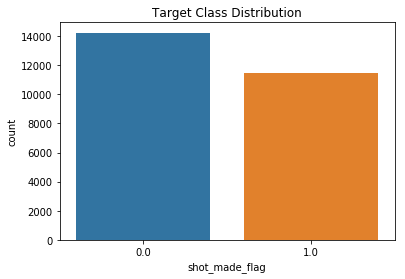

In [17]:
xy = plt.axes()
sns.countplot(x='shot_made_flag', data=df, ax=xy);
xy.set_title('Target Class Distribution')
plt.show()

Here we encode all object types

In [18]:
for i in df.columns:
    if df[i].dtypes=='object':
        print(df[i].head())

0            Jump Shot
1            Jump Shot
2            Jump Shot
3            Jump Shot
4    Driving Dunk Shot
Name: action_type, dtype: object
0    Jump Shot
1    Jump Shot
2    Jump Shot
3    Jump Shot
4         Dunk
Name: combined_shot_type, dtype: object
0    1
1    1
2    1
3    1
4    2
Name: period, dtype: object
0    2000
1    2000
2    2000
3    2000
4    2000
Name: season, dtype: object
0            Right Side(R)
1             Left Side(L)
2     Left Side Center(LC)
3    Right Side Center(RC)
4                Center(C)
Name: shot_zone_area, dtype: object
0          Mid-Range
1          Mid-Range
2          Mid-Range
3          Mid-Range
4    Restricted Area
Name: shot_zone_basic, dtype: object
0          16-24 ft.
1           8-16 ft.
2          16-24 ft.
3          16-24 ft.
4    Less Than 8 ft.
Name: shot_zone_range, dtype: object
0    2000-10-31
1    2000-10-31
2    2000-10-31
3    2000-10-31
4    2000-10-31
Name: game_date, dtype: object
0    POR
1    POR
2    POR
3  

Here we convert categorical variable into dummy/indicator variables

In [19]:
df=pd.get_dummies(df)

## Feature Selection

Split data into train and test


In [20]:
holdout=df[df['shot_made_flag'].isnull()]
data=df[df['shot_made_flag'].notnull()]

y=data['shot_made_flag']
X=data.drop(['shot_made_flag', 'shot_id'], axis=1)

Train Test Split

In [21]:
X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=42, test_size=0.3)

## Testing

In [22]:
#Logistic Regression
classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, average=False)
#average =False, alpha= 10.0)
#Not sure if we need to implement alpha or if we need to optimize
classifier.fit(X_train, y_train)
#print("LOGISTIC REGRESSION--"" Number of SGD iterations: %d" % classifier.n_iter_ )
print("LOGISTIC REGRESSION--"" Training accuracy: %0.6f" % accuracy_score(y_train, classifier.predict(X_train)))
print("LOGISTIC REGRESSION--"" Testing accuracy: %0.6f" % accuracy_score(y_test, classifier.predict(X_test)))
print("")

############################

#Decision Tree
classifier = DecisionTreeClassifier(max_depth=100, min_samples_leaf=10, random_state=123)
classifier.fit(X_train, y_train)
print("DECISION TREE--"" Training accuracy: %0.6f" % accuracy_score(y_train, classifier.predict(X_train)))
print("DECISION TREE--"" Test accuracy: %0.6f" % accuracy_score(y_test, classifier.predict(X_test)))
print("")

############################

#Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=1000, max_depth=1000, min_samples_leaf=5, random_state=123)
classifier.fit(X_train, y_train)
print("RANDOM FOREST--"" Training accuracy: %0.6f" % accuracy_score(y_train, classifier.predict(X_train)))
print("RANDOM FOREST--"" Test accuracy: %0.6f" % accuracy_score(y_test, classifier.predict(X_test)))
print("")

############################

#MLP Classifier
classifier=MLPClassifier(hidden_layer_sizes=(200,200), random_state=123)
classifier.fit(X_train, y_train)
print("MLP CLASSIFIER--"" Training accuracy: %0.6f" % accuracy_score(y_train, classifier.predict(X_train)))
print("MLP CLASSIFIER--"" Test accuracy: %0.6f" % accuracy_score(y_test, classifier.predict(X_test)))
print("")

############################

#GaussianNB
classifier = GaussianNB(priors=None, var_smoothing=1e-09)
classifier.fit(X_train, y_train)
print("GAUSSIAN NB--"" Training accuracy: %0.6f" % accuracy_score(y_train, classifier.predict(X_train)))
print("GAUSSIAN NB--"" Test accuracy: %0.6f" % accuracy_score(y_test, classifier.predict(X_test)))
print("")

LOGISTIC REGRESSION-- Training accuracy: 0.446878
LOGISTIC REGRESSION-- Testing accuracy: 0.444488

DECISION TREE-- Training accuracy: 0.780786
DECISION TREE-- Test accuracy: 0.610376

RANDOM FOREST-- Training accuracy: 0.687775
RANDOM FOREST-- Test accuracy: 0.662905

MLP CLASSIFIER-- Training accuracy: 0.446878
MLP CLASSIFIER-- Test accuracy: 0.444488

GAUSSIAN NB-- Training accuracy: 0.553122
GAUSSIAN NB-- Test accuracy: 0.555512



## Error Analysis

In [24]:
classifier = MLPClassifier(hidden_layer_sizes=(200,200), random_state=123)
classifier.fit(X_train, y_train)
confusion_matrix(y_test,classifier.predict(X_test))

array([[   0, 4283],
       [   0, 3427]], dtype=int64)

In [25]:
classifier = GaussianNB(priors=None, var_smoothing=1e-09)
classifier.fit(X_train, y_train)
confusion_matrix(y_test,classifier.predict(X_test))

array([[4283,    0],
       [3427,    0]], dtype=int64)

In [26]:
classifier = RandomForestClassifier(n_estimators=1000, max_depth=1000, min_samples_leaf=5, random_state=123)
classifier.fit(X_train, y_train)
confusion_matrix(y_test,classifier.predict(X_test))

array([[3406,  877],
       [1722, 1705]], dtype=int64)

In [27]:
classifier = DecisionTreeClassifier(max_depth=100, min_samples_leaf=10, random_state=123)
classifier.fit(X_train, y_train)
confusion_matrix(y_test,classifier.predict(X_test))

array([[2987, 1296],
       [1708, 1719]], dtype=int64)

In [28]:
classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, average=False)
classifier.fit(X_train, y_train)
confusion_matrix(y_test,classifier.predict(X_test))

array([[   0, 4283],
       [   0, 3427]], dtype=int64)

#

HERE IS THE LOGISTIC REGRESSION CLASSIFIER WE USED AFTER TRYING OUT A DIFFERENT FEATURE SELECTION(THIS IS SHOWN LATER IN NOTEBOOK

In [53]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score using Logistic Regression:", acc*100)

Accuracy score using Logistic Regression: 59.44228274967575


In [67]:
confusion_matrix(y_test,model.predict(X_test))

array([[3164, 1060],
       [2067, 1419]], dtype=int64)

## Error Analysis Outcome

For our error analysis of the random forest classifier, it was interesting to see just how significant 30% in accuracy deficiency can have on this type of prediction. However, it was interesting to see Decision Tree have less error given that was is overfitted. Although the algorithms performance were better than we hoped, I still wouldn't be confident in using this for predicting an NBA player’s success when making a shot.

For the other error arrays we made. We weren't quite sure why it was producing the scores that it was. Some of these classifiers may not have been appropriate for the data we had or the type of prediction we made. 


## Looking at weight distribution to see greatest influencer and which features are predictive (However, we couldn't figure out how to script this properly and ended up with a hard to interpret visual

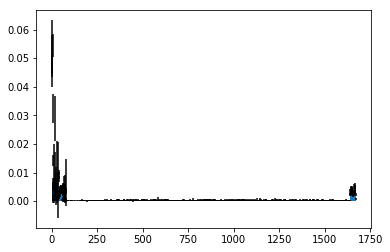

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

clf = RandomForestClassifier()
clf.fit(X_train.values, y_train.values.ravel())
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=X_train.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in clf.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]

plt.bar(x, y, yerr=yerr, align="center")

plt.show()

In [40]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score

classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, average=False)
classifier.fit(X_train, y_train)
print("Number of SGD iterations: %d" % classifier.n_iter_)

print("\nFeature weights:")
args = np.argsort(classifier.coef_[0])
#for a in args:
    #print(" %s: %0.4f" % (data[a], classifier.coef_[0][a])) 
    
#This wouldn't and we couldn't figure out why    

Number of SGD iterations: 267

Feature weights:


## Messing with select features for testing: Predicting Kobe Bryant Shot successful based solely on shot distance from basket

In [56]:
import pandas as pd 
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline

In [57]:
df = pd.read_csv("data_sql.csv")
df = df.dropna()
df.head(10)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,124.0,29600044.0,33.8633,-142.0,181.0,-118.4118,8.0,2.0,...,3PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1.610613e+09,Los Angeles Lakers,11/6/96,LAL @ CHH,CHA,22904.0
1,Jump Shot,Jump Shot,151.0,29600044.0,33.9063,-10.0,138.0,-118.2798,5.0,2.0,...,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1.610613e+09,Los Angeles Lakers,11/6/96,LAL @ CHH,CHA,22906.0
2,Jump Shot,Jump Shot,226.0,29600057.0,33.8213,-64.0,223.0,-118.3338,2.0,2.0,...,3PT Field Goal,Center(C),Mid-Range,16-24 ft.,1.610613e+09,Los Angeles Lakers,11/8/96,LAL @ TOR,TOR,22908.0
3,Jump Shot,Jump Shot,337.0,29600057.0,33.8373,-103.0,207.0,-118.3728,1.0,3.0,...,3PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1.610613e+09,Los Angeles Lakers,11/8/96,LAL @ TOR,TOR,22911.0
4,Jump Shot,Jump Shot,153.0,29600086.0,33.9323,-151.0,112.0,-118.4208,6.0,2.0,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1.610613e+09,Los Angeles Lakers,11/12/96,LAL @ HOU,HOU,22918.0
5,Layup Shot,Layup,426.0,29600095.0,34.0443,0.0,0.0,-118.2698,1.0,4.0,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1.610613e+09,Los Angeles Lakers,11/13/96,LAL @ SAS,SAS,22920.0
6,Jump Shot,Jump Shot,453.0,29600095.0,33.9043,188.0,140.0,-118.0818,0.0,4.0,...,3PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1.610613e+09,Los Angeles Lakers,11/13/96,LAL @ SAS,SAS,22921.0
7,Jump Shot,Jump Shot,141.0,29600112.0,34.0293,-157.0,15.0,-118.4268,9.0,2.0,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1.610613e+09,Los Angeles Lakers,11/15/96,LAL vs. LAC,LAC,22922.0
8,Jump Shot,Jump Shot,163.0,29600126.0,33.8153,62.0,229.0,-118.2078,5.0,2.0,...,3PT Field Goal,Center(C),Mid-Range,16-24 ft.,1.610613e+09,Los Angeles Lakers,11/17/96,LAL @ PHX,PHX,22928.0
9,Jump Shot,Jump Shot,304.0,29600126.0,33.8893,-170.0,155.0,-118.4398,0.0,3.0,...,3PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1.610613e+09,Los Angeles Lakers,11/17/96,LAL @ PHX,PHX,22931.0


In [58]:
df.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')

In [59]:
y_target = df['shot_made_flag']
#y_target

In [60]:
df['target'] = df['shot_made_flag'].map({0:'B',1:'M'})

In [61]:
features = ['shot_distance', 'shot_made_flag']
X_feature = df[features]

In [62]:
from sklearn.model_selection import train_test_split
X_feature.drop(columns=['shot_made_flag'], inplace=True)

In [63]:
X_feature

,shot_distance
0,23.0
1,13.0
2,23.0
3,23.0
4,18.0
5,0.0
6,23.0
7,15.0
8,23.0
9,23.0


In [64]:
X_train, X_test, y_train, y_test= train_test_split(X_feature, y_target, test_size=0.3, random_state = 42)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [65]:
model = LogisticRegression()
#y_train

In [66]:
model.fit(X_train, y_train)
#y_train

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
from mlxtend.plotting import plot_decision_regions

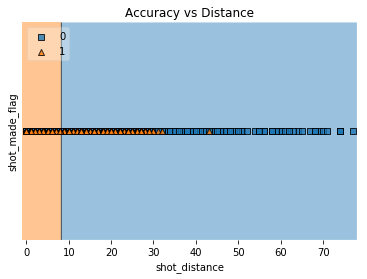

In [18]:
y=y_train.values.astype(int)
plot_decision_regions(X_train.values, y, clf=model, legend=2)

plt.title("Accuracy vs Distance")
plt.ylabel("shot_made_flag")
plt.xlabel("shot_distance")
plt.figure(figsize=(100,200))

In [19]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score using Logistic Regression:", acc*100)

Accuracy score using Logistic Regression: 59.44228274967575


In [52]:
confusion_matrix(y_test,model.predict(X_test))

array([[3164, 1060],
       [2067, 1419]], dtype=int64)

## Working Section (Parts 4,5,6)
### (4)Where are Kobes strongest and weakest shooting zones?(chart/analysis)
    Answer: Strongest (Right Side), Weakest(Center) --- see chart below for support
    
### (5)Over his entire career was Kobe a more accurate 3-point or 2-point shooter?(chart/analysis)
    Answer: More accurate 2-point shooter. Career 3-point only about 31%(potential bias-due to more shot distribution wihtin 2 point range.) --- see chart below for support
    
### (6)What year/game/playoff series was Kobe the most accurate in his shooting percentage?(chart/analysis)
    Answer: Year(2002-2003)Shots Made(1000+)Missed(800), Game(1/22/2006)(Team_Id:Raptors), Playoff(1st Series)(Due to early career prime/lack of career injuries) --- see chart below for support
    

## (4)Where are Kobes strongest and weakest shooting zones?(chart/analysis)
### What attributes contribute to shot choice selection?

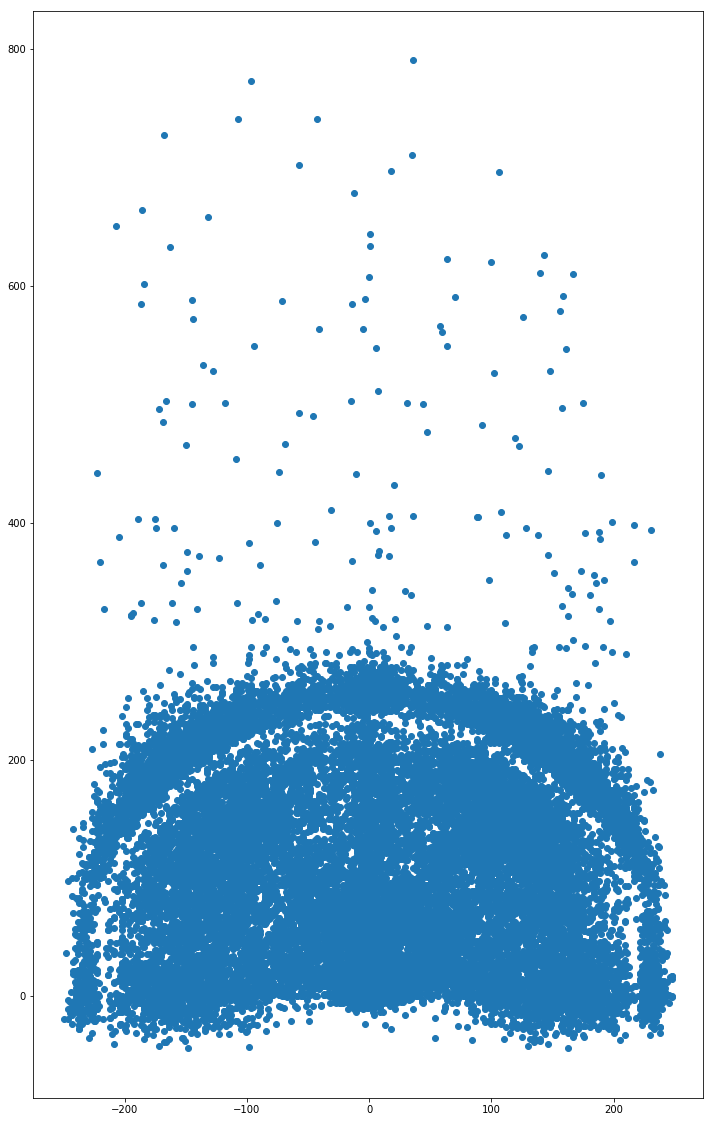

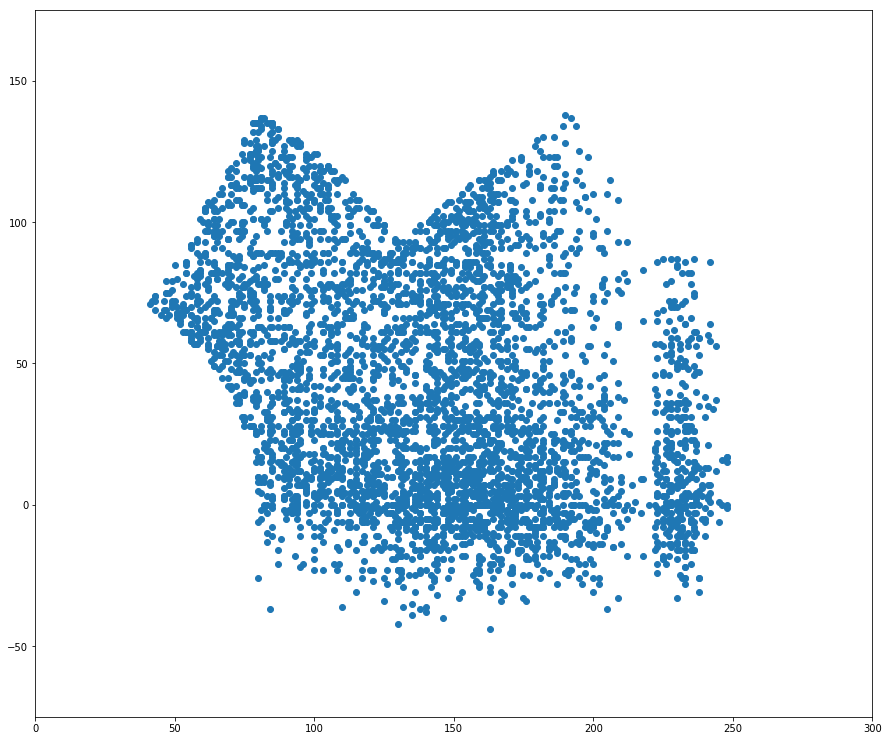

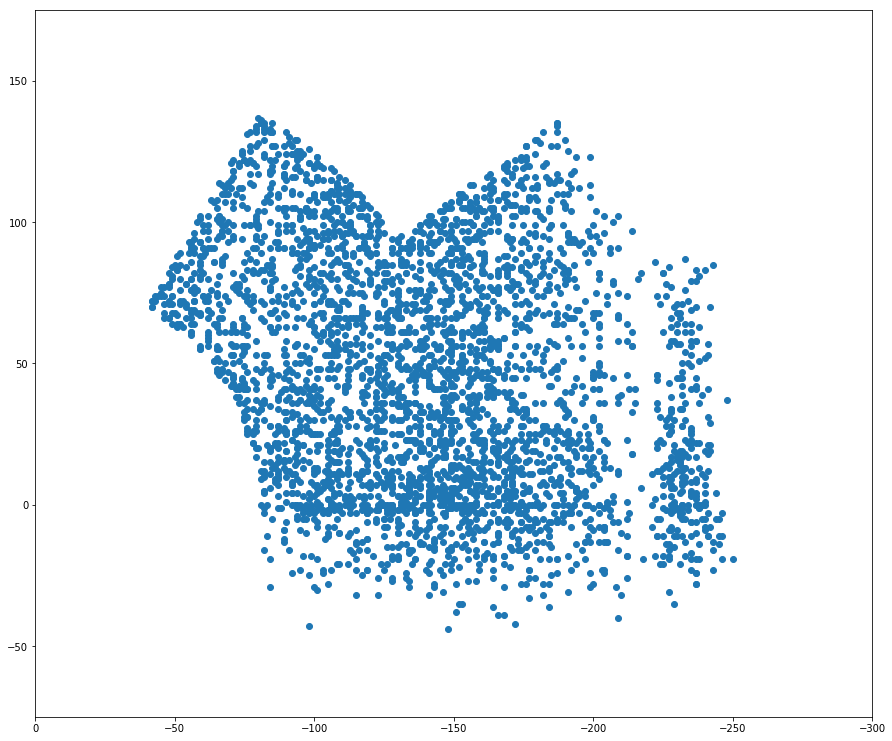

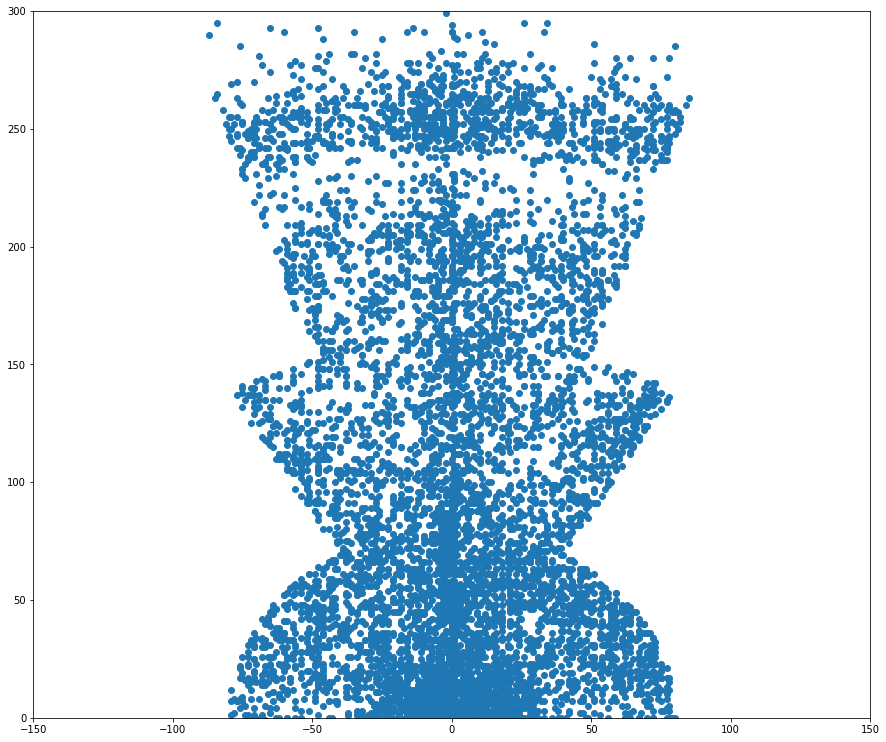

In [3]:
# RAW PLOTS, Gives good representation of where shots were taken. Plots create outline of court.
# column types(shot_distance	shot_made_flag	shot_type	shot_zone_area	shot_zone_basic	shot_zone_range)
# Getting a sence of what Kobes data contains. This raw plot show the mass amount of shot selections we have to work with. Needs cleaning/reformating to get a clear understanding.
df = pd.read_csv("data_sql.csv")
#sns.set_style("white")
#sns.set_color_codes()
#All shots/Action Type
plt.figure(figsize=(12,20))
plt.scatter(df.loc_x, df.loc_y)
plt.show()

#Adjusting to shot zone area(R)
shot_zone_plt = df[df.shot_zone_area == "Right Side(R)"]
plt.figure(figsize=(15,13))
plt.xlim(0,300)
plt.ylim(-75,175)
plt.scatter(shot_zone_plt.loc_x, shot_zone_plt.loc_y)
plt.show()

#Adjusting to shot zone area(L)(I WANT TO SET THESE SO THEY ARE ALL SIDE BY SIDE)
shot_zone_plt = df[df.shot_zone_area == "Left Side(L)"]
plt.figure(figsize=(15,13))
plt.xlim(0,-300)
plt.ylim(-75,175)
plt.scatter(shot_zone_plt.loc_x, shot_zone_plt.loc_y)
plt.show()

#Adjusting to shot zone area(C)(CANT FIND POINT PLOT YET)(Check other shot columns...)
shot_zone_plt = df[df.shot_zone_area == "Center(C)"]
plt.figure(figsize=(15,13))
plt.xlim(-150,150)
plt.ylim(0,300)
plt.scatter(shot_zone_plt.loc_x, shot_zone_plt.loc_y)
plt.show()

## Ploting NBA Cort Lines(Open Sourced)
### Gathering A Better Visual Representation Of Plots

(-100, 500)

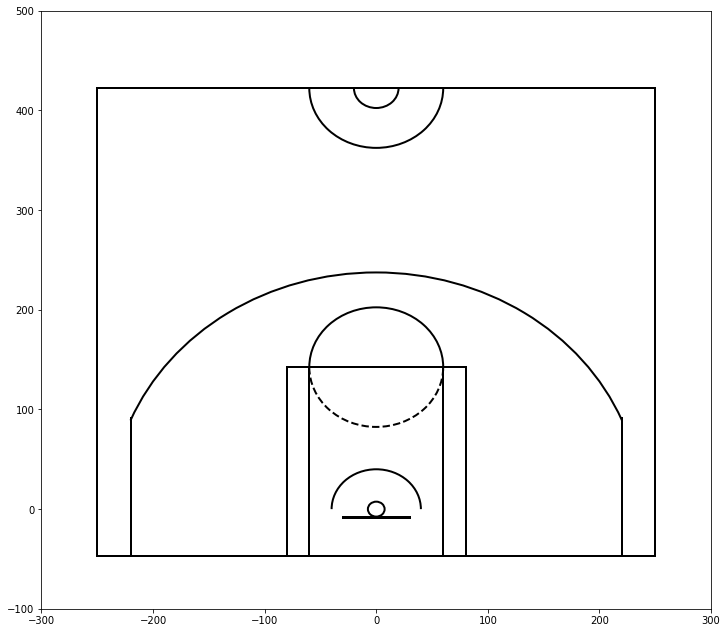

In [4]:
# Create a NBA basketball court visual line plot
#Sourced From......."savvastjortjoglou"
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    if ax is None:
        ax = plt.gca()
        
    # Create the basketball hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    # The paint
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)
    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)
    # Three point line
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)
    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    if outer_lines:
        # Half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)
    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)

### Based on this new visualization render for the plot we can verify we have data outside the proper range. Lets analyize the data, clean and continue plot.

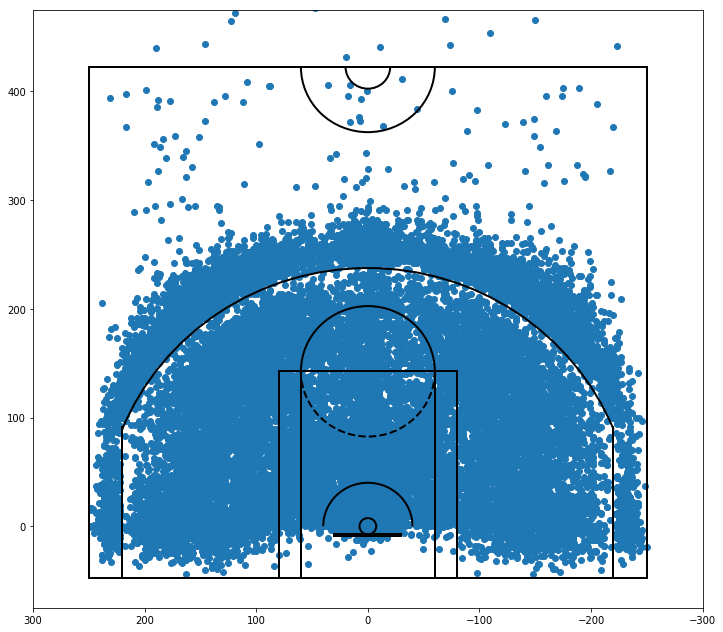

In [5]:
#RE-Plot fig 1 To COURT MAP
plt.figure(figsize=(12,11))
plt.scatter(df.loc_x, df.loc_y)
draw_court(outer_lines=True)
# Descending values along the axis from left to right
plt.xlim(300,-300)
plt.ylim(-75,475)
plt.show()

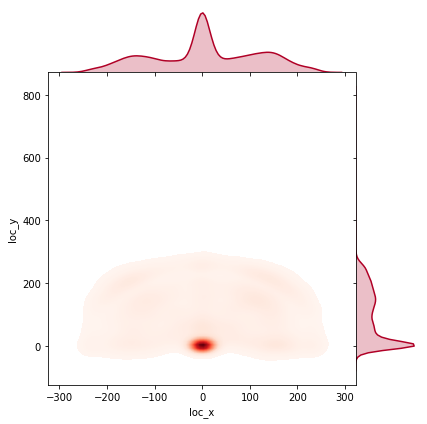

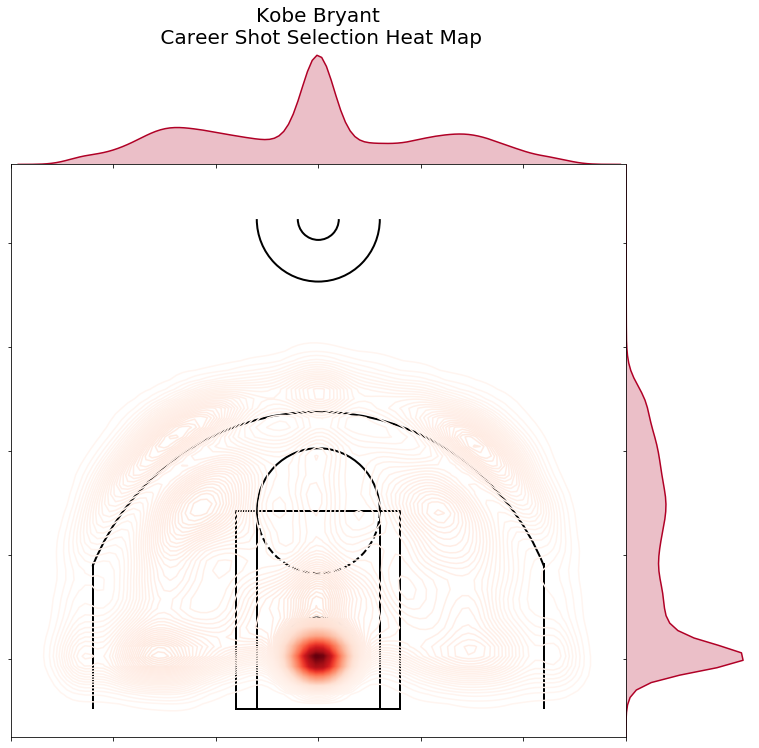

In [6]:
from matplotlib.offsetbox import OffsetImage
#Create Heat Map of Kobe shot selection(NEXT I WANT TO SPLIT (MAKE=1(o),MISS=0(x)))

# Note we can extract a color from cmap
cmap=plt.cm.YlOrRd_r

heat_map_shot_chart = sns.jointplot(df.loc_x, df.loc_y, stat_func=None, kind='kde', space=0, color=cmap(0.1), cmap="Reds", shade_lowest=False, n_levels=300)
heat_map_shot_chart = sns.jointplot(df.loc_x, df.loc_y, stat_func=None, kind='kde', space=0, color=cmap(0.1), cmap="Reds", shade=False, n_levels=500)

heat_map_shot_chart.fig.set_size_inches(12,11)
ax = heat_map_shot_chart.ax_joint
draw_court(ax)
ax.set_title('Kobe Bryant\n Career Shot Selection Heat Map', y=1.2, fontsize=20)
ax.set_xlim(300,-300)
ax.set_ylim(-75,475)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')
plt.show()

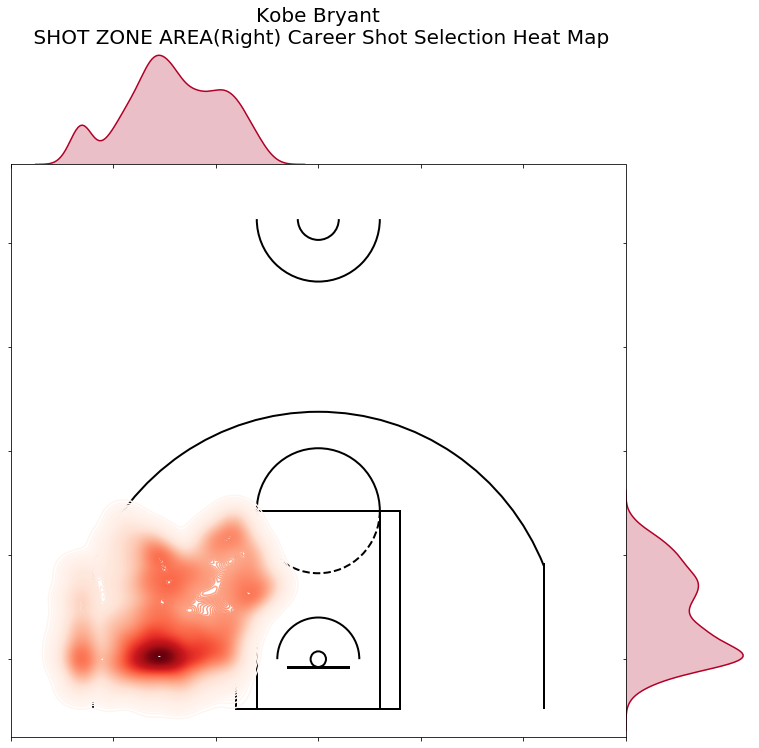

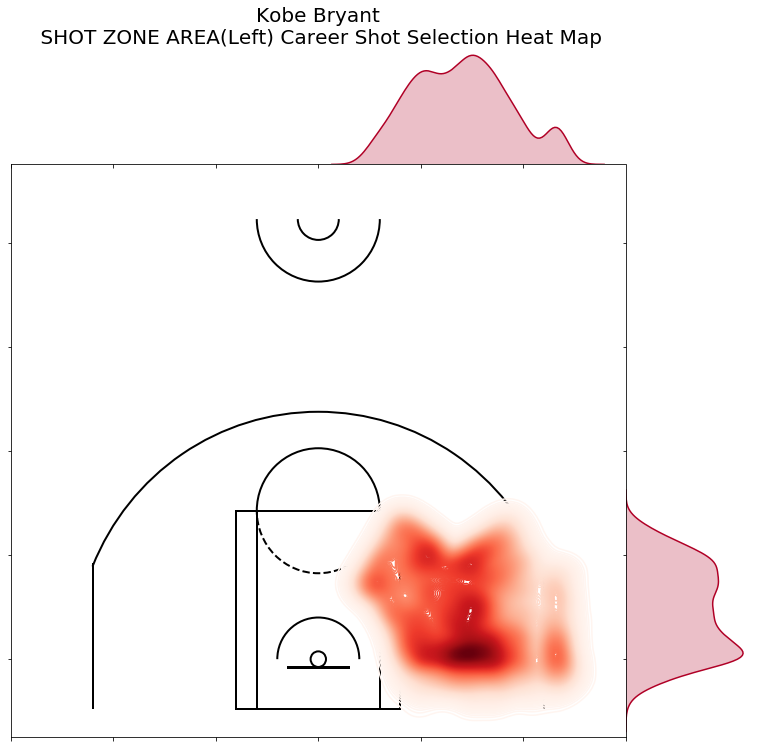

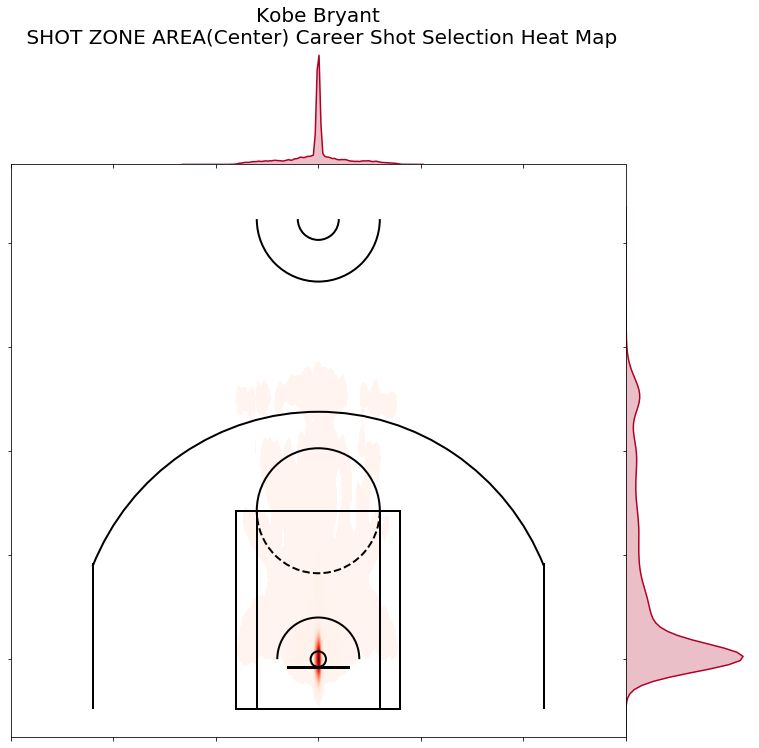

In [7]:
#PLOT ON MAP (ALL SHOT ZONE AREAS)
#RIGHT SIDE HEAT MAP
right_shot_zone_plt = df[df.shot_zone_area == "Right Side(R)"]

right_heat_map_shot_chart = sns.jointplot(right_shot_zone_plt.loc_x, right_shot_zone_plt.loc_y, stat_func=None, kind='kde', space=0, color=cmap(0.1), cmap="Reds", shade=False, n_levels=500)

right_heat_map_shot_chart.fig.set_size_inches(12,11)
ax = right_heat_map_shot_chart.ax_joint
draw_court(ax)
ax.set_title('Kobe Bryant\n SHOT ZONE AREA(Right) Career Shot Selection Heat Map', y=1.2, fontsize=20)
ax.set_xlim(300,-300)
ax.set_ylim(-75,475)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')
plt.show()

#LEFT SHOT HEAT MAP
left_shot_zone_plt = df[df.shot_zone_area == "Left Side(L)"]

left_heat_map_shot_chart = sns.jointplot(left_shot_zone_plt.loc_x, left_shot_zone_plt.loc_y, stat_func=None, kind='kde', space=0, color=cmap(0.1), cmap="Reds", shade=False, n_levels=500)

left_heat_map_shot_chart.fig.set_size_inches(12,11)
ax = left_heat_map_shot_chart.ax_joint
draw_court(ax)
ax.set_title('Kobe Bryant\n SHOT ZONE AREA(Left) Career Shot Selection Heat Map', y=1.2, fontsize=20)
ax.set_xlim(300,-300)
ax.set_ylim(-75,475)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')
plt.show()

#CENTER SHOT HEAT MAP
center_shot_zone_plt = df[df.shot_zone_area == "Center(C)"]

center_heat_map_shot_chart = sns.jointplot(center_shot_zone_plt.loc_x, center_shot_zone_plt.loc_y, stat_func=None, kind='kde', space=0, color=cmap(0.1), cmap="Reds", shade_lowest=False, n_levels=500)

center_heat_map_shot_chart.fig.set_size_inches(12,11)
ax = center_heat_map_shot_chart.ax_joint
draw_court(ax)
ax.set_title('Kobe Bryant\n SHOT ZONE AREA(Center) Career Shot Selection Heat Map', y=1.2, fontsize=20)
ax.set_xlim(300,-300)
ax.set_ylim(-75,475)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')
plt.show()

Text(0,0.5,'Shot Distance')

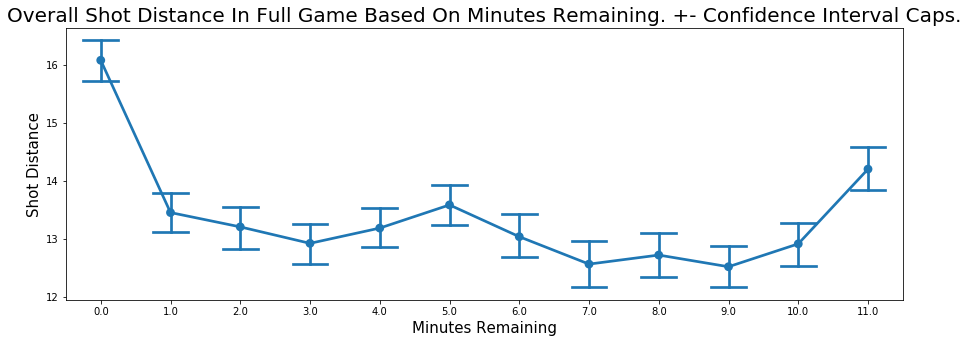

In [8]:
#import seaborn as sns; sns.set()
#import matplotlib.pyplot as plt

# Overall shot distance in a complete game based on the minutes remaining. +- confidence interval.
plt.figure(figsize=(15,5))
plt.title('Overall Shot Distance In Full Game Based On Minutes Remaining. +- Confidence Interval Caps.', fontsize=20)
shot_dist_conf_int = sns.pointplot(x="minutes_remaining", y="shot_distance", capsize=.5, data=df)
plt.xlabel("Minutes Remaining", fontsize=15)
plt.ylabel("Shot Distance",fontsize=15)

Text(0,0.5,'Shot Distance')

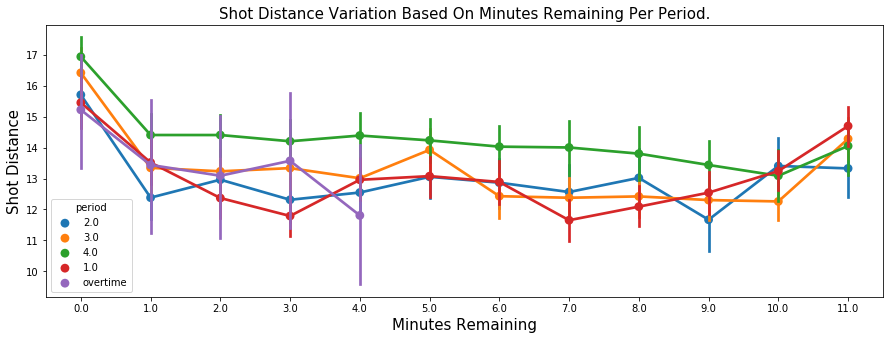

In [10]:
# Shot distance variation based on minutes remaining per period.
# If error, re run period/overtime code block.
overtime = np.array([5, 6, 7])
df.loc[df['period'].isin(overtime), 'period'] = 'overtime'
df['period'].value_counts()

plt.figure(figsize=(15,5))
plt.title('Shot Distance Variation Based On Minutes Remaining Per Period.', fontsize=15)
plt.legend(loc='bottom left')
shot_dist_per_min = sns.pointplot(x="minutes_remaining", y="shot_distance", hue="period", data=df)
plt.xlabel("Minutes Remaining", fontsize=15)
plt.ylabel("Shot Distance",fontsize=15)

## (5) Over his entire career was Kobe a more accurate 3-point or 2-point shooter?(chart/analysis)

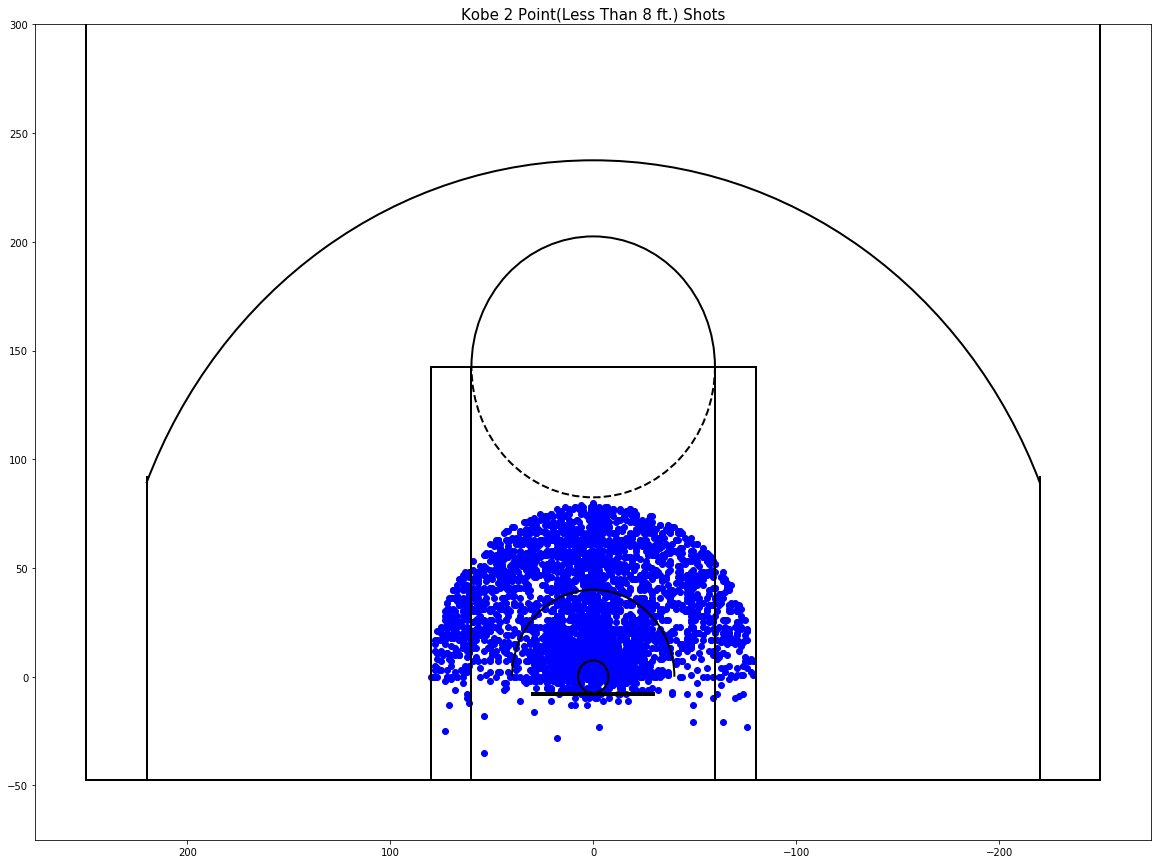

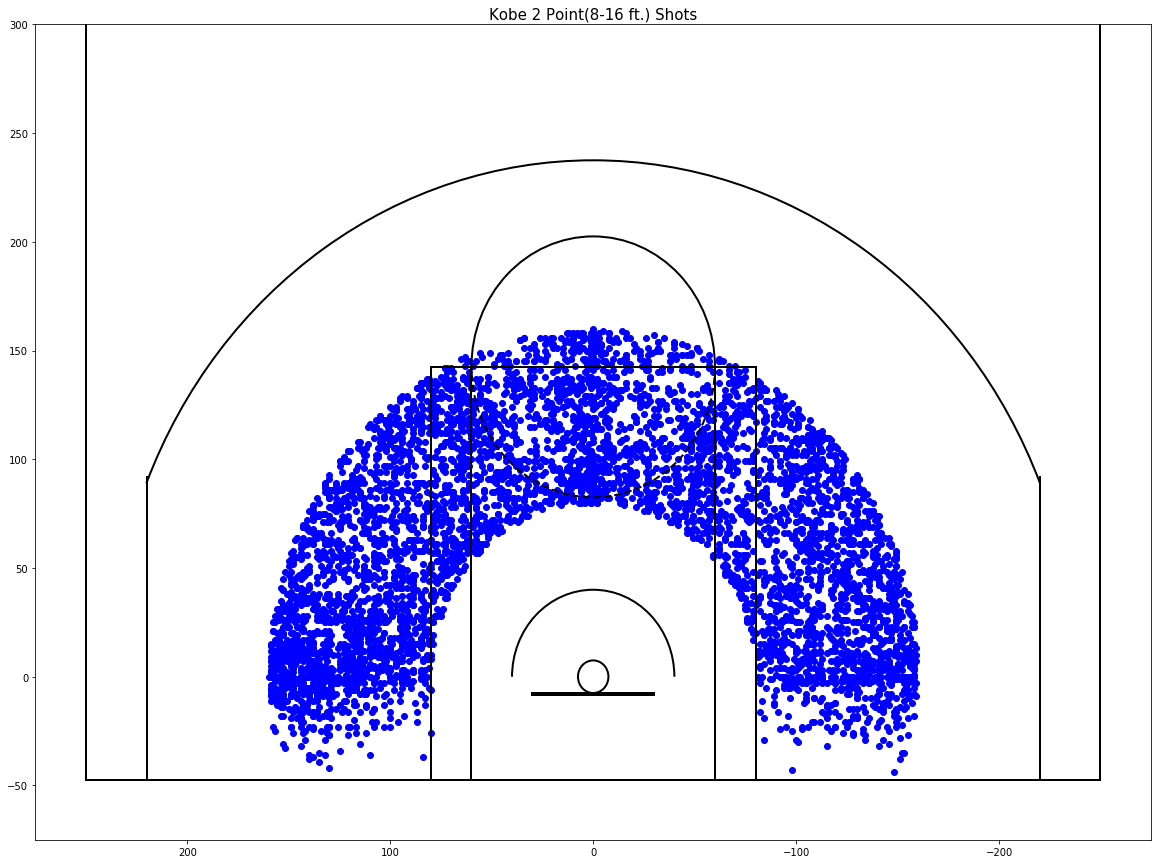

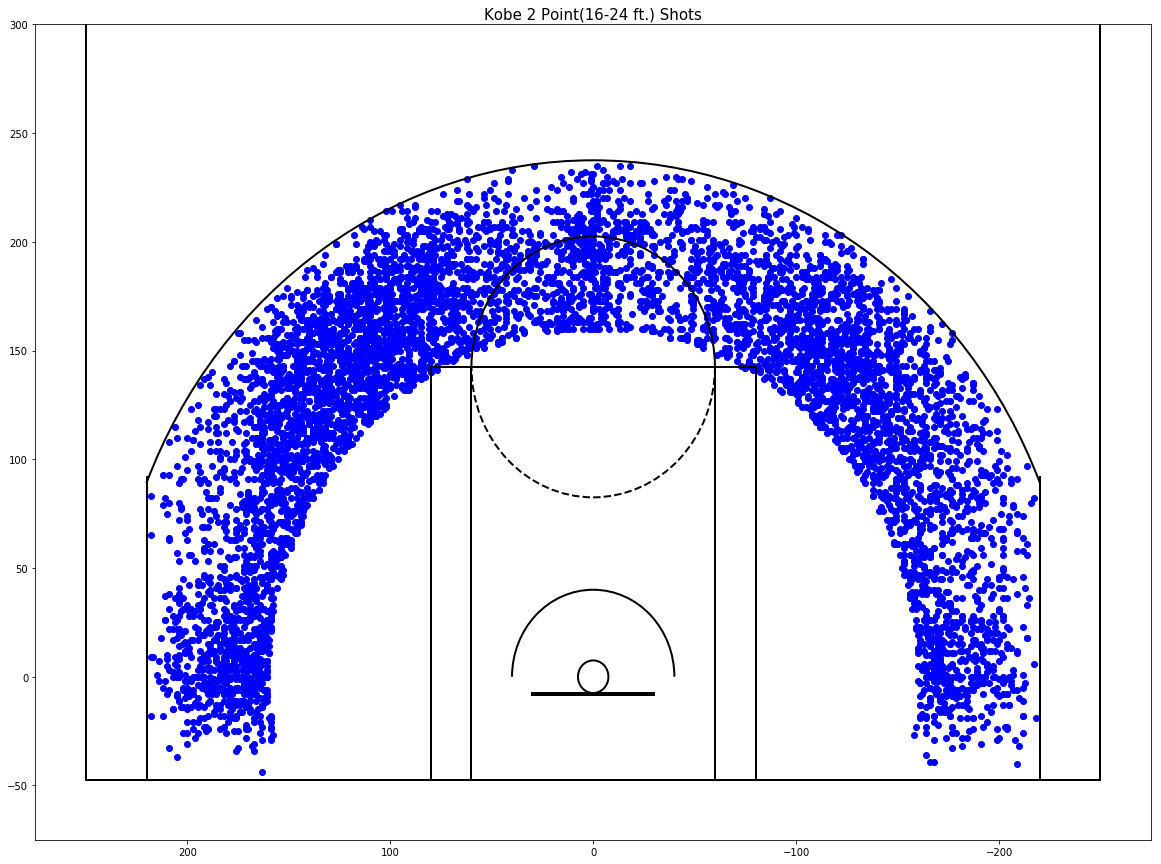

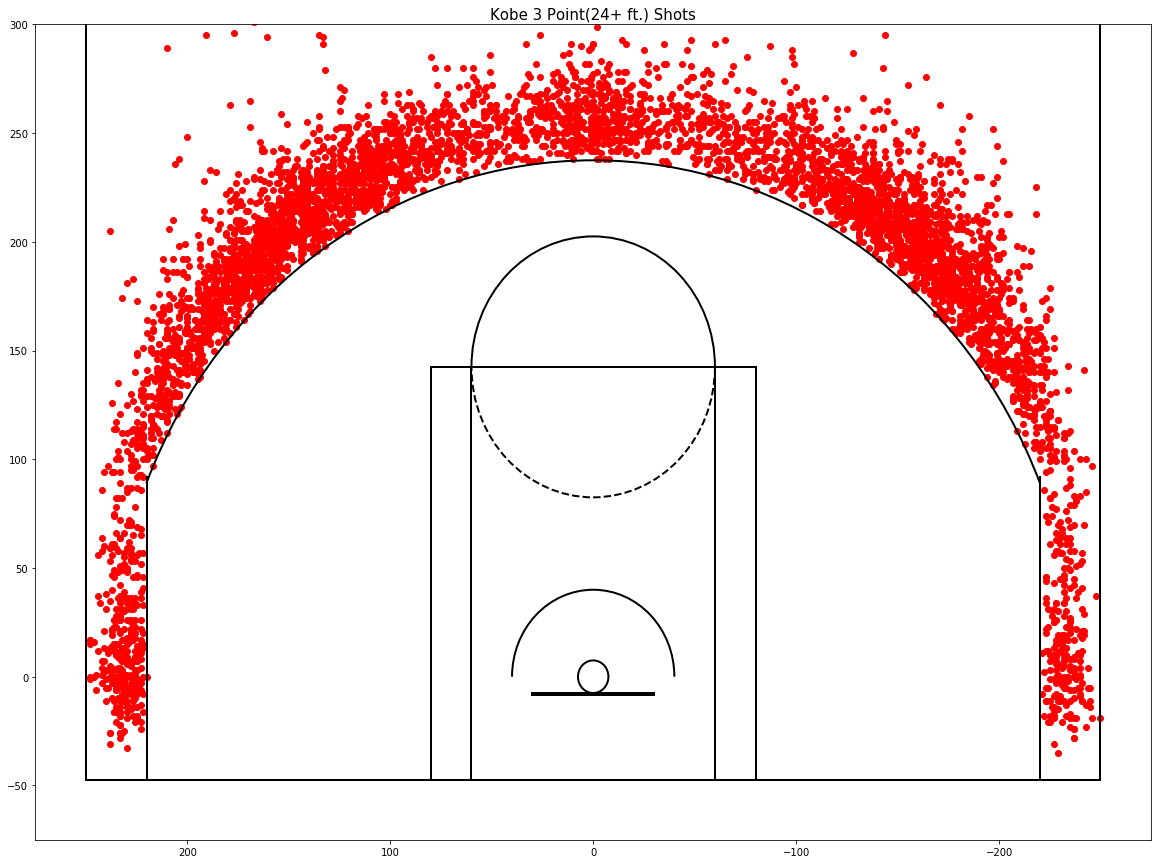

In [11]:
df = pd.read_csv("data_sql.csv")
df = df.dropna()

plt.figure(figsize=(20,15))
ax = df.loc[df.shot_zone_range == 'Less Than 8 ft.']
plt.scatter(ax.loc_x, ax.loc_y, color='blue')
draw_court(outer_lines=True)
plt.title('Kobe 2 Point(Less Than 8 ft.) Shots', fontsize=15)
plt.xlim(275,-275)
plt.ylim(-75,300)
plt.show()

plt.figure(figsize=(20,15))
ax = df.loc[df.shot_zone_range == '8-16 ft.']
plt.scatter(ax.loc_x, ax.loc_y, color='blue')
draw_court(outer_lines=True)
plt.title('Kobe 2 Point(8-16 ft.) Shots', fontsize=15)
plt.xlim(275,-275)
plt.ylim(-75,300)
plt.show()

plt.figure(figsize=(20,15))
ax = df.loc[df.shot_zone_range == '16-24 ft.']
plt.scatter(ax.loc_x, ax.loc_y, color='blue')
draw_court(outer_lines=True)
plt.title('Kobe 2 Point(16-24 ft.) Shots', fontsize=15)
plt.xlim(275,-275)
plt.ylim(-75,300)
plt.show()

plt.figure(figsize=(20,15))
ax = df.loc[df.shot_zone_range == '24+ ft.']
plt.scatter(ax.loc_x, ax.loc_y, color='red')
draw_court(outer_lines=True)
plt.title('Kobe 3 Point(24+ ft.) Shots', fontsize=15)
plt.xlim(275,-275)
plt.ylim(-75,300)
plt.show()

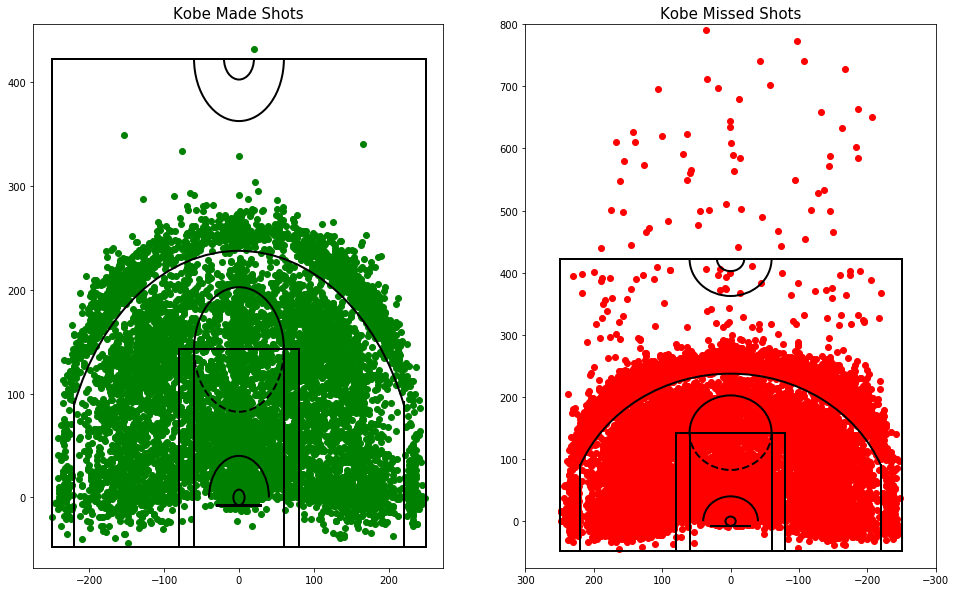

In [13]:
#Create plots on court to visualize Kobe's made(1) and missed(0) shooting attempts over his career.
plt.figure(figsize=(25,10))
# Made Shots(1)
plt.subplot(131)
ax = df.loc[df.shot_made_flag == 1]
plt.scatter(ax.loc_x, ax.loc_y, color='green')
draw_court(outer_lines=True)
plt.title('Kobe Made Shots', fontsize=15)

# Missed Shots(0)
plt.subplot(132)
ax = df.loc[df.shot_made_flag == 0]
plt.scatter(ax.loc_x, ax.loc_y, color='red')
draw_court(outer_lines=True)
plt.title('Kobe Missed Shots', fontsize=15)
plt.xlim(300,-300)
plt.ylim(-75,800)
plt.show()

## (6)What year/game/playoff series was Kobe the most accurate in his shooting percentage?

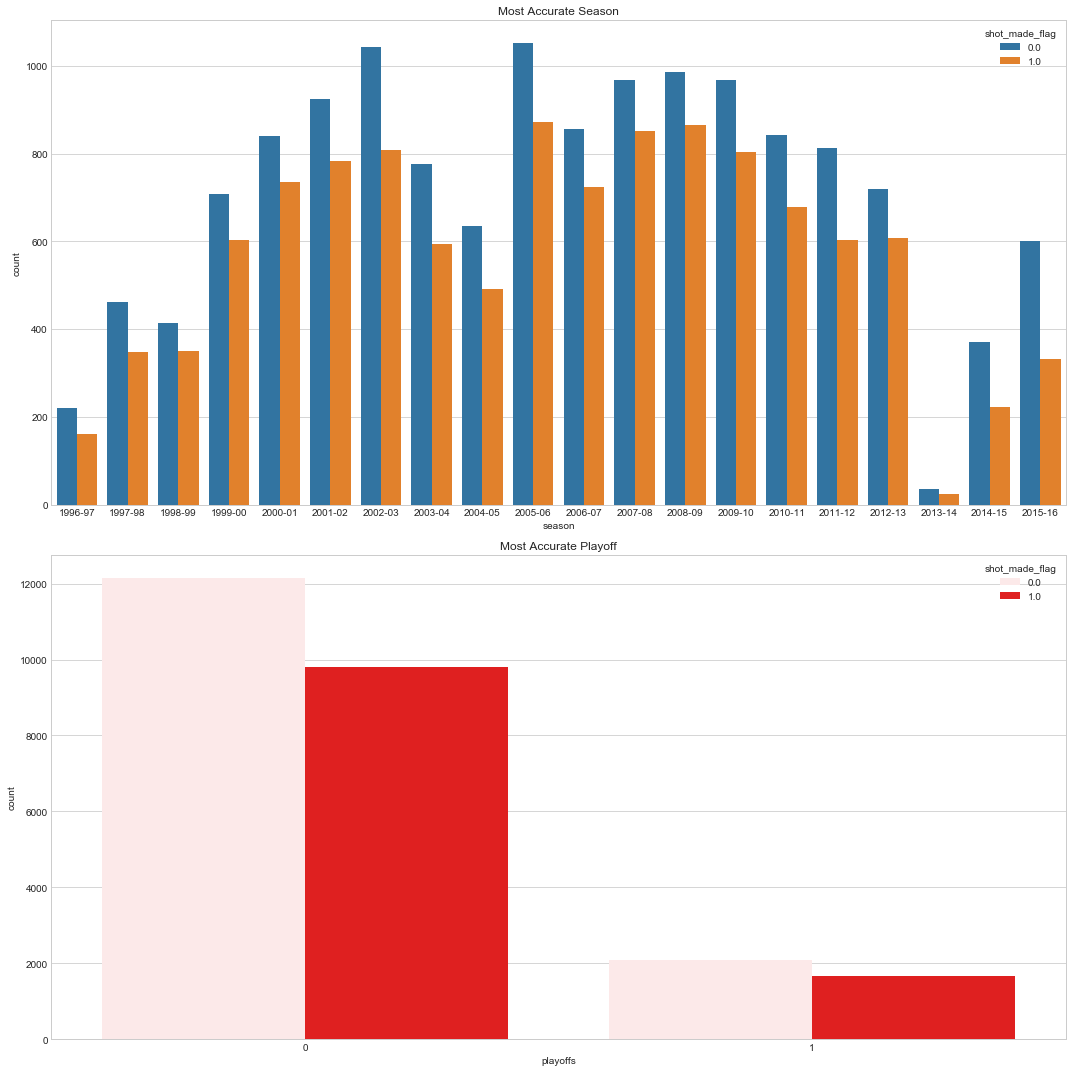

In [36]:
f, axarr = plt.subplots(2, figsize=(15, 15))
sns.countplot(x="season", hue="shot_made_flag", data=data, ax=axarr[0])
axarr[0].set_title('Most Accurate Season')
plt.tight_layout()
#plt.show()

# Playoffs
sns.countplot(x="playoffs", hue="shot_made_flag", data=data, ax=axarr[1], color='red')
axarr[1].set_title('Most Accurate Playoff')
plt.tight_layout()
plt.show()

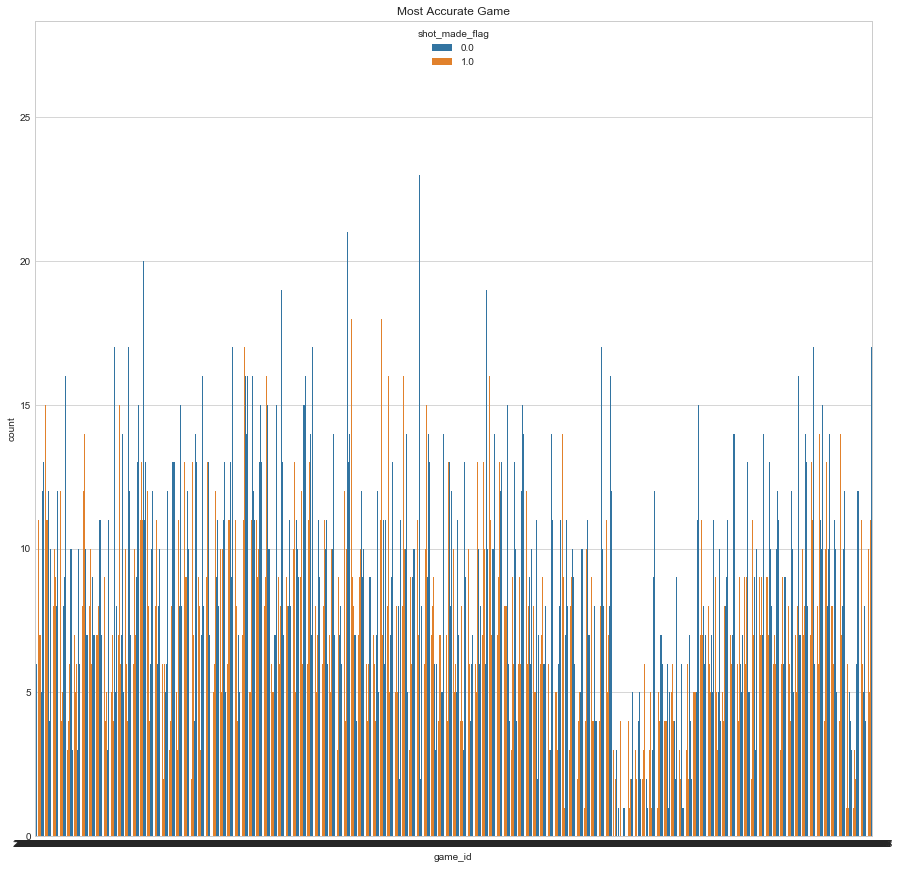

In [53]:
# Game
plt.figure(figsize=(15,15))
sns.countplot(x="game_id", hue="shot_made_flag", data=data)
plt.fontsize=(3)
plt.title('Most Accurate Game')
#plt.tight_layout()
plt.show()
#sns_plot.savefig("output.png")

## Working Section (Parts 7,8,9)
### (7)Was Kobe a more accurate shooter in the playoffs or regular season?(chart/analysis)
       Answer: Regular Season(potential bias- due to dispreportion between amout of playoff and regualr season games. --- See chart below

### (8)What was Kobe’s most accurate type of shot?(chart/analysis)
       Answer: Jump Shot (1), Layup (2), Dunk(3)  --- See chart below

### (9)What year did Kobe make/miss the most attempted shots?(chart/analysis)
       Answer: Best year = 2005-2006, Worst = 2013-2014 (injury)  --- See chart below 

In [14]:
#matplotlib
%matplotlib inline 

#warning filtration
import warnings
warnings.filterwarnings('ignore')

#import basic package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import sklearn
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier

#used to display all columns
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

In [15]:
data = pd.read_csv('data.csv')

#set an index and coverted some columns into categorical (this helped generate better summarization)
data.set_index('shot_id', inplace=True)
data["action_type"] = data["action_type"].astype('object')
data["combined_shot_type"] = data["combined_shot_type"].astype('category')
data["game_event_id"] = data["game_event_id"].astype('category')
data["game_id"] = data["game_id"].astype('category')
data["period"] = data["period"].astype('object')
data["playoffs"] = data["playoffs"].astype('category')
data["season"] = data["season"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["team_id"] = data["team_id"].astype('category')

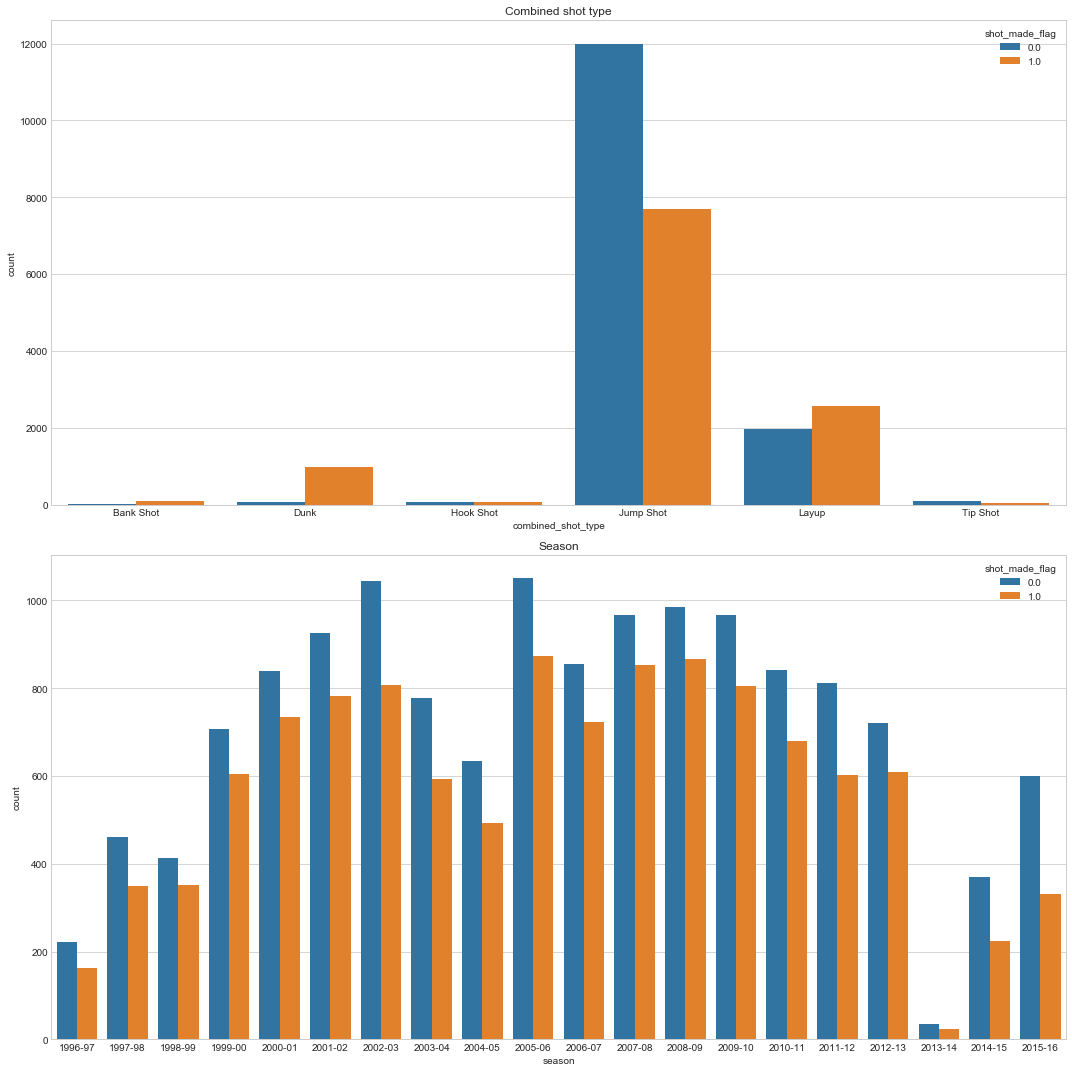

In [16]:
#For the visualization, I used the sns.countplot with f, axarr to structure the plots.
f, axarr = plt.subplots(2, figsize=(15, 15))

sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=data, ax=axarr[0])

sns.countplot(x="season", hue="shot_made_flag", data=data, ax=axarr[1])

#axarr.set_title for both plots
axarr[0].set_title('Combined shot type')

axarr[1].set_title('Season')

#print visualizations
plt.tight_layout()
plt.show()

## References

In [29]:
#https://www.kaggle.com/c/kobe-bryant-shot-selection/data
#https://www.kaggle.com/kernels?sortBy=relevance&group=everyone&search=Kobe+Machine+Learning&page=1&pageSize=20
#https://www.kaggle.com/kanncaa1/machine-learning-tutorial-for-beginners
#https://www.kaggle.com/narimiran/a-beginners-attempt-in-ml/notebook 
#https://www.kaggle.com/khozzy/kobe-shots-show-me-your-best-model 
#https://www.kaggle.com/pauzzz/kobe-shot-predict-xgb-logisticregression-base/code 